# Hotel Sales Analysis : Determining Potential Customer
### Created By : Donny Rizki Septian

## Business Problem Understanding

**Context**  
Sebuah perusahaan di portugal yang bergerak di bidang perhotelan ingin mengurangi biaya operasional yang digunakan secara tidak efisien. Perusahaan telah memperoleh data transaksi booking oleh customer baik transaksi yang terselesaikan maupun yang terbatalkan dengan berbagai macam metode book seperti online booking, offline booking, maupun booking melalui travel agent atau tour. Perusahaan ingin mengetahui customer mana yang berpotensi membatalkan transaksi dan mana yang tidak agar perusahaan dapat mengoptimalkan layanan yang diberikan kepada para customer dan proses operasional dapat berjalan lebih efisien secara budgeting.

Target :

0 : Transaksi Selesai

1 : Transaksi Dibatalkan

**Problem Statement :**

Proses transaksi membutuhkan waktu yang tidak begitu lama, namum customer memiliki kebutuhan tertentu yang harus dipenuhi perusahaan baik itu type kamar atau pun kebutuhan lain seperti lahan parkir yang tersedia jika customer tersebut akan stay dalam waktu yang lama.

Jika persiapan untuk memenuhi kebetuhan customer tersebut sudah dijalankan oleh pihak hotel namum customer malah membatalkan transaksi, tentu saja ini dapat merugikan perusahaan karena perusahaan sudah mengeluarkan sumber daya dan waktu yang lebih untuk transaksi tersebut.

Untuk transaksi seperti customer yang ingin stay dalam waktu yang singkat, perusahaan juga sering mendapati transaksi yang dibatalkan dan ini perlu ditelusuri lebih lanjut apakah ada faktor tertentu yang mempengaruhi keputusan customer dalam membatalkan transaksi.

**Goals :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang akan membatalkan transaksi atau tidak, sehingga perusahaan juga dapat memberikan layanan yang maksimal tanpa harus mengalami transaksi yang gagal setelah memberikan waktu dan sumber daya yang lebih untuk suatu request dalam transaksi.

Dan juga, perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat seorang customer memutuskan untuk membatalkan transaksi atau tidak, sehingga perusahaan dapat membuat suatu rekomendasi layanan tertentu untuk para calon customer.

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan customer yang memiliki potensi untuk membatalkan transaksi.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang customer untuk membatalkan transaksi tersebut atau tidak.

**Metric Evaluation**

Type 1 error : False Positive  
Konsekuensi: kehilangan calon customer yang benar benar loyal

Type 2 error : False Negative  
Konsekuensi: sia-sianya transaksi dalam segi waktu dan sumber daya

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mendukung untuk menemukan calon customer yang membatalkan transaksi, dengan sesedikit mungkin prediksi false positive. Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.

| Actual | Positive | Negative |
| --- | --- | --- |
Positive | TP | FN
Negative | FP | TN 



## Data Understanding



Dataset source : https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

Note : 
- Dataset tidak memiliki data unique, kita dapat berasumsi bahwa sebagian besar data merupakan duplikasi
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary)
- Setiap baris data merepresentasikan informasi transaksi yang dilakukan oleh customer hingga order tersebut selesai atau dibatalkan



### Attribute Information

| Attribute | Data Type | Description |
| --- | --- | --- |
country | Object | Country of origin.
market_segment | Object | Market segment designation. 
previous_cancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking.
booking_changes | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
deposit_type | Object | Indication on if the customer made a deposit to guarantee the booking. 
days_in_waiting_list | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer.
customer_type | Object | Type of booking.
reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons.
required_car_parking_space | Integer | Number of car parking spaces required by the customer.
total_of_special_request | Integer | Number of special requests made by the customer (e.g. twin bed or high floor).
is_canceled | Integer | Value indicating if the booking was canceled (1) or not (0).


In [1]:
# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import category_encoders as ce


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from scikitplot.metrics import plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
display(df['is_canceled'].value_counts())

0    52795
1    30778
Name: is_canceled, dtype: int64

## Data Cleaning

Dataset ini diasumsikan memiliki duplikasi data yang cukup banyak karena tidak adanya kolom data yang unik seperti list ID dari customer, jadi untuk langkah awal kita akan meng-handle data duplikasi dengan drop sebagai berikut.

**Handling Duplicate Data**

Pertama kita check terlebih dahulu jumlah data unik yang ada dan akan kita compare dengan jumlah data keseluruhan yaitu 83,573 data.

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc


(83573, 11)


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[OMN, CN]"
1,market_segment,object,0,0.00,8,"[Groups, Undefined]"
2,previous_cancellations,int64,0,0.00,15,"[1, 21]"
3,booking_changes,int64,0,0.00,19,"[12, 0]"
4,deposit_type,object,0,0.00,3,"[Refundable, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[69, 44]"
6,customer_type,object,0,0.00,4,"[Contract, Group]"
7,reserved_room_type,object,0,0.00,10,"[H, L]"
8,required_car_parking_spaces,int64,0,0.00,5,"[1, 3]"
9,total_of_special_requests,int64,0,0.00,6,"[2, 5]"


Seperti yang dapat kita lihat di atas, jumlah data unik dari setiap kolom hanya sedikit jika dibandingkan dengan total keseluruhan data. Dengan ini dapat diasumsikan bahwa dataset memiliki data duplikasi yang banyak. Maka, kita akan men-drop / delete datanya seperti berikut.

In [6]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
83568     True
83569     True
83570     True
83571     True
83572     True
Length: 83573, dtype: bool

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
#Load Dataset Again
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10202 entries, 0 to 83565
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      10084 non-null  object
 1   market_segment               10202 non-null  object
 2   previous_cancellations       10202 non-null  int64 
 3   booking_changes              10202 non-null  int64 
 4   deposit_type                 10202 non-null  object
 5   days_in_waiting_list         10202 non-null  int64 
 6   customer_type                10202 non-null  object
 7   reserved_room_type           10202 non-null  object
 8   required_car_parking_spaces  10202 non-null  int64 
 9   total_of_special_requests    10202 non-null  int64 
 10  is_canceled                  10202 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 956.4+ KB


In [10]:
display(df['is_canceled'].value_counts())

0    7788
1    2414
Name: is_canceled, dtype: int64

Setelah kita delete data duplikat-nya, hanya terdapat 10,202 untuk total keseluruhan data. Setelah ini, kita dapat melanjutkan untuk handle missing value pada dataset.

**Handling Missing Value**

Mari kita check terlebih dahulu column mana yang masih memiliki missing value.

In [11]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc


(10202, 11)


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,118,1.16,162,"[PRY, ISL]"
1,market_segment,object,0,0.00,8,"[Offline TA/TO, Groups]"
2,previous_cancellations,int64,0,0.00,15,"[3, 19]"
3,booking_changes,int64,0,0.00,19,"[16, 10]"
4,deposit_type,object,0,0.00,3,"[Non Refund, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[74, 23]"
6,customer_type,object,0,0.00,4,"[Group, Contract]"
7,reserved_room_type,object,0,0.00,10,"[H, B]"
8,required_car_parking_spaces,int64,0,0.00,5,"[2, 3]"
9,total_of_special_requests,int64,0,0.00,6,"[3, 1]"


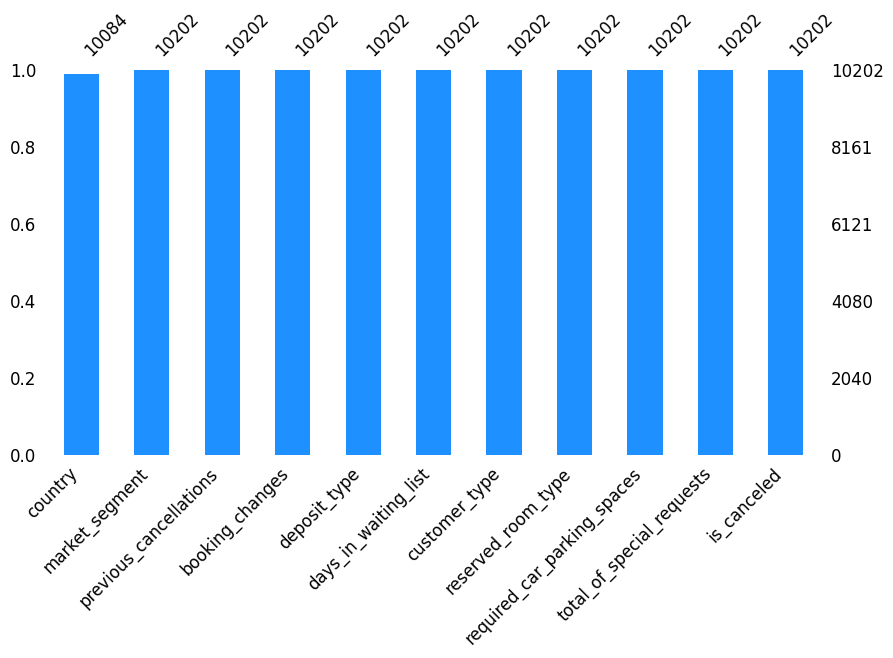

In [12]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Seperti yang dapat kita lihat pada table di atas, missing value hanya terdapat pada column country saja. Karena jumlah juga sangat sedikit, maka kita dapat men-delete saja row dengan missing value pada column country.

In [13]:
df.dropna(subset=['country'],inplace=True)

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(10084, 11)


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[ZAF, BFA]"
1,market_segment,object,0,0.0,8,"[Complementary, Offline TA/TO]"
2,previous_cancellations,int64,0,0.0,15,"[1, 0]"
3,booking_changes,int64,0,0.0,19,"[16, 9]"
4,deposit_type,object,0,0.0,3,"[Refundable, Non Refund]"
5,days_in_waiting_list,int64,0,0.0,115,"[215, 80]"
6,customer_type,object,0,0.0,4,"[Contract, Transient]"
7,reserved_room_type,object,0,0.0,10,"[G, L]"
8,required_car_parking_spaces,int64,0,0.0,5,"[0, 1]"
9,total_of_special_requests,int64,0,0.0,6,"[1, 3]"


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10084 entries, 0 to 83565
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      10084 non-null  object
 1   market_segment               10084 non-null  object
 2   previous_cancellations       10084 non-null  int64 
 3   booking_changes              10084 non-null  int64 
 4   deposit_type                 10084 non-null  object
 5   days_in_waiting_list         10084 non-null  int64 
 6   customer_type                10084 non-null  object
 7   reserved_room_type           10084 non-null  object
 8   required_car_parking_spaces  10084 non-null  int64 
 9   total_of_special_requests    10084 non-null  int64 
 10  is_canceled                  10084 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 945.4+ KB


In [15]:
df.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

Seperti yang dapat dilihat pada table di atas, semua missing value sudah ter-handle dan total data keseluruhan berjumlah 10,084 data. Selanjutnya kita akan melakukan cleaning lebih dalam pada setiap variable yang kita butuhkan dalam analisis.

**market_segment**

Mari kita lihat terlebih dahulu data apa saja yang terdapat pada column ini.

In [16]:
display(df['market_segment'].value_counts())

Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Undefined           1
Name: market_segment, dtype: int64

Untuk data "Undefined", kita akan delete saja karena data ini bisa dianggap sebagai data NaN/Null.

In [17]:
df['market_segment'] = df['market_segment'].replace('Undefined',None)
df.dropna(subset=['market_segment'],inplace=True)
display(df['market_segment'].value_counts())

Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Name: market_segment, dtype: int64

**deposit_type**

Untuk column deposit type, kita akan ubah sedikit datanya dengan pertimbangan sebagai berikut.
1. No Deposit : Karena tidak menguntungkan perusahaan maka akan kita ubah menjadi "Loss"
2. Non Refund : Karena menguntungkan perusahaan maka akan kita ubah menjadi "Gain"
3. Refundable : Karena tidak menguntungkan perusahaan maka akan kita ubah menjadi "Loss" Juga

In [18]:
display(df['deposit_type'].value_counts())

No Deposit    9842
Non Refund     194
Refundable      47
Name: deposit_type, dtype: int64

In [19]:
df.loc[df['deposit_type'] == 'No Deposit', 'deposit_type'] = "Loss"
df.loc[df['deposit_type'] == 'Non Refund', 'deposit_type'] = "Gain"
df.loc[df['deposit_type'] == 'Refundable', 'deposit_type'] = "Loss"

df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,Loss,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,Loss,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,Loss,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,Loss,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,Loss,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83515,GBR,Direct,0,2,Loss,0,Transient-Party,A,1,1,0
83543,CHN,Online TA,0,0,Loss,0,Transient-Party,C,0,2,0
83554,BEL,Groups,0,0,Loss,0,Transient-Party,A,0,1,0
83562,NLD,Online TA,0,0,Loss,0,Transient,B,0,0,0


In [20]:
display(df['deposit_type'].value_counts())

Loss    9889
Gain     194
Name: deposit_type, dtype: int64

**customer_type**

Untuk customer type, kita juga akan mengubah datanya dengan pertimbangan sebagai berikut:
1. Transient        : Menetap dalam jangka waktu pendek = "Short Stay"
2. Transient-Party  : Menetap dalam jangka waktu pendek = "Short Stay"
3. Contract         : Menetap dalam jangka waktu panjang = "Long Stay"
4. Group            : Menetap dalam jangka waktu panjang = "Long Stay"

In [21]:
display(df['customer_type'].value_counts())

Transient          6813
Transient-Party    2548
Contract            481
Group               241
Name: customer_type, dtype: int64

In [22]:
df.loc[df['customer_type'] == 'Transient', 'customer_type'] = "Short Stay"
df.loc[df['customer_type'] == 'Transient-Party', 'customer_type'] = "Short Stay"
df.loc[df['customer_type'] == 'Contract', 'customer_type'] = "Long Stay"
df.loc[df['customer_type'] == 'Group', 'customer_type'] = "Long Stay"

df


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,Loss,0,Short Stay,A,0,0,0
1,FRA,Online TA,0,0,Loss,0,Short Stay,A,0,2,0
2,PRT,Online TA,0,1,Loss,0,Short Stay,A,0,2,0
3,NLD,Online TA,0,0,Loss,0,Short Stay,A,0,1,1
4,PRT,Online TA,0,2,Loss,0,Short Stay,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83515,GBR,Direct,0,2,Loss,0,Short Stay,A,1,1,0
83543,CHN,Online TA,0,0,Loss,0,Short Stay,C,0,2,0
83554,BEL,Groups,0,0,Loss,0,Short Stay,A,0,1,0
83562,NLD,Online TA,0,0,Loss,0,Short Stay,B,0,0,0


In [23]:
display(df['customer_type'].value_counts())

Short Stay    9361
Long Stay      722
Name: customer_type, dtype: int64

**days_in_waiting_list**

Untuk column berikut karena range-nya begitu jauh,
maka akan kita perkecil lagi dengan mengkategorikan sebagai berikut:
1. 0-29 akan dibiarkan
2. Untuk values diatas 30 akan kita ubah menjadi >30

In [24]:
df['days_in_waiting_list'] = np.where(df['days_in_waiting_list'] > 29, ">30", df['days_in_waiting_list'])

In [25]:
display(df['days_in_waiting_list'].value_counts())

0      9618
>30     354
4        13
15       13
25        7
1         7
14        7
6         6
27        6
17        5
22        4
20        4
11        3
5         3
13        3
10        3
21        3
8         3
28        3
3         2
16        2
18        2
2         2
9         2
12        2
23        2
24        1
19        1
26        1
7         1
Name: days_in_waiting_list, dtype: int64

In [26]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(10083, 11)


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[TUR, NOR]"
1,market_segment,object,0,0.0,7,"[Direct, Corporate]"
2,previous_cancellations,int64,0,0.0,15,"[14, 3]"
3,booking_changes,int64,0,0.0,19,"[6, 3]"
4,deposit_type,object,0,0.0,2,"[Loss, Gain]"
5,days_in_waiting_list,object,0,0.0,30,"[12, 16]"
6,customer_type,object,0,0.0,2,"[Long Stay, Short Stay]"
7,reserved_room_type,object,0,0.0,10,"[E, L]"
8,required_car_parking_spaces,int64,0,0.0,5,"[2, 1]"
9,total_of_special_requests,int64,0,0.0,6,"[1, 5]"


Sekarang data yang kita miliki sudah bersih, mari sekarang kita lanjut ke tahap Analisa Datanya untuk keperluan masalah kita.

## Data Analysis

Dalam data analysis kita akan menggunakan beberapa tools dengan pertimbangan sebagai berikut:
1. Barplot untuk data object dengan unique data yang sedikit
2. Kita akan menggunakan table perbanding yang lebih detail untuk column country karena unique datanya yang banyak.

**Histogram & Box Plot**

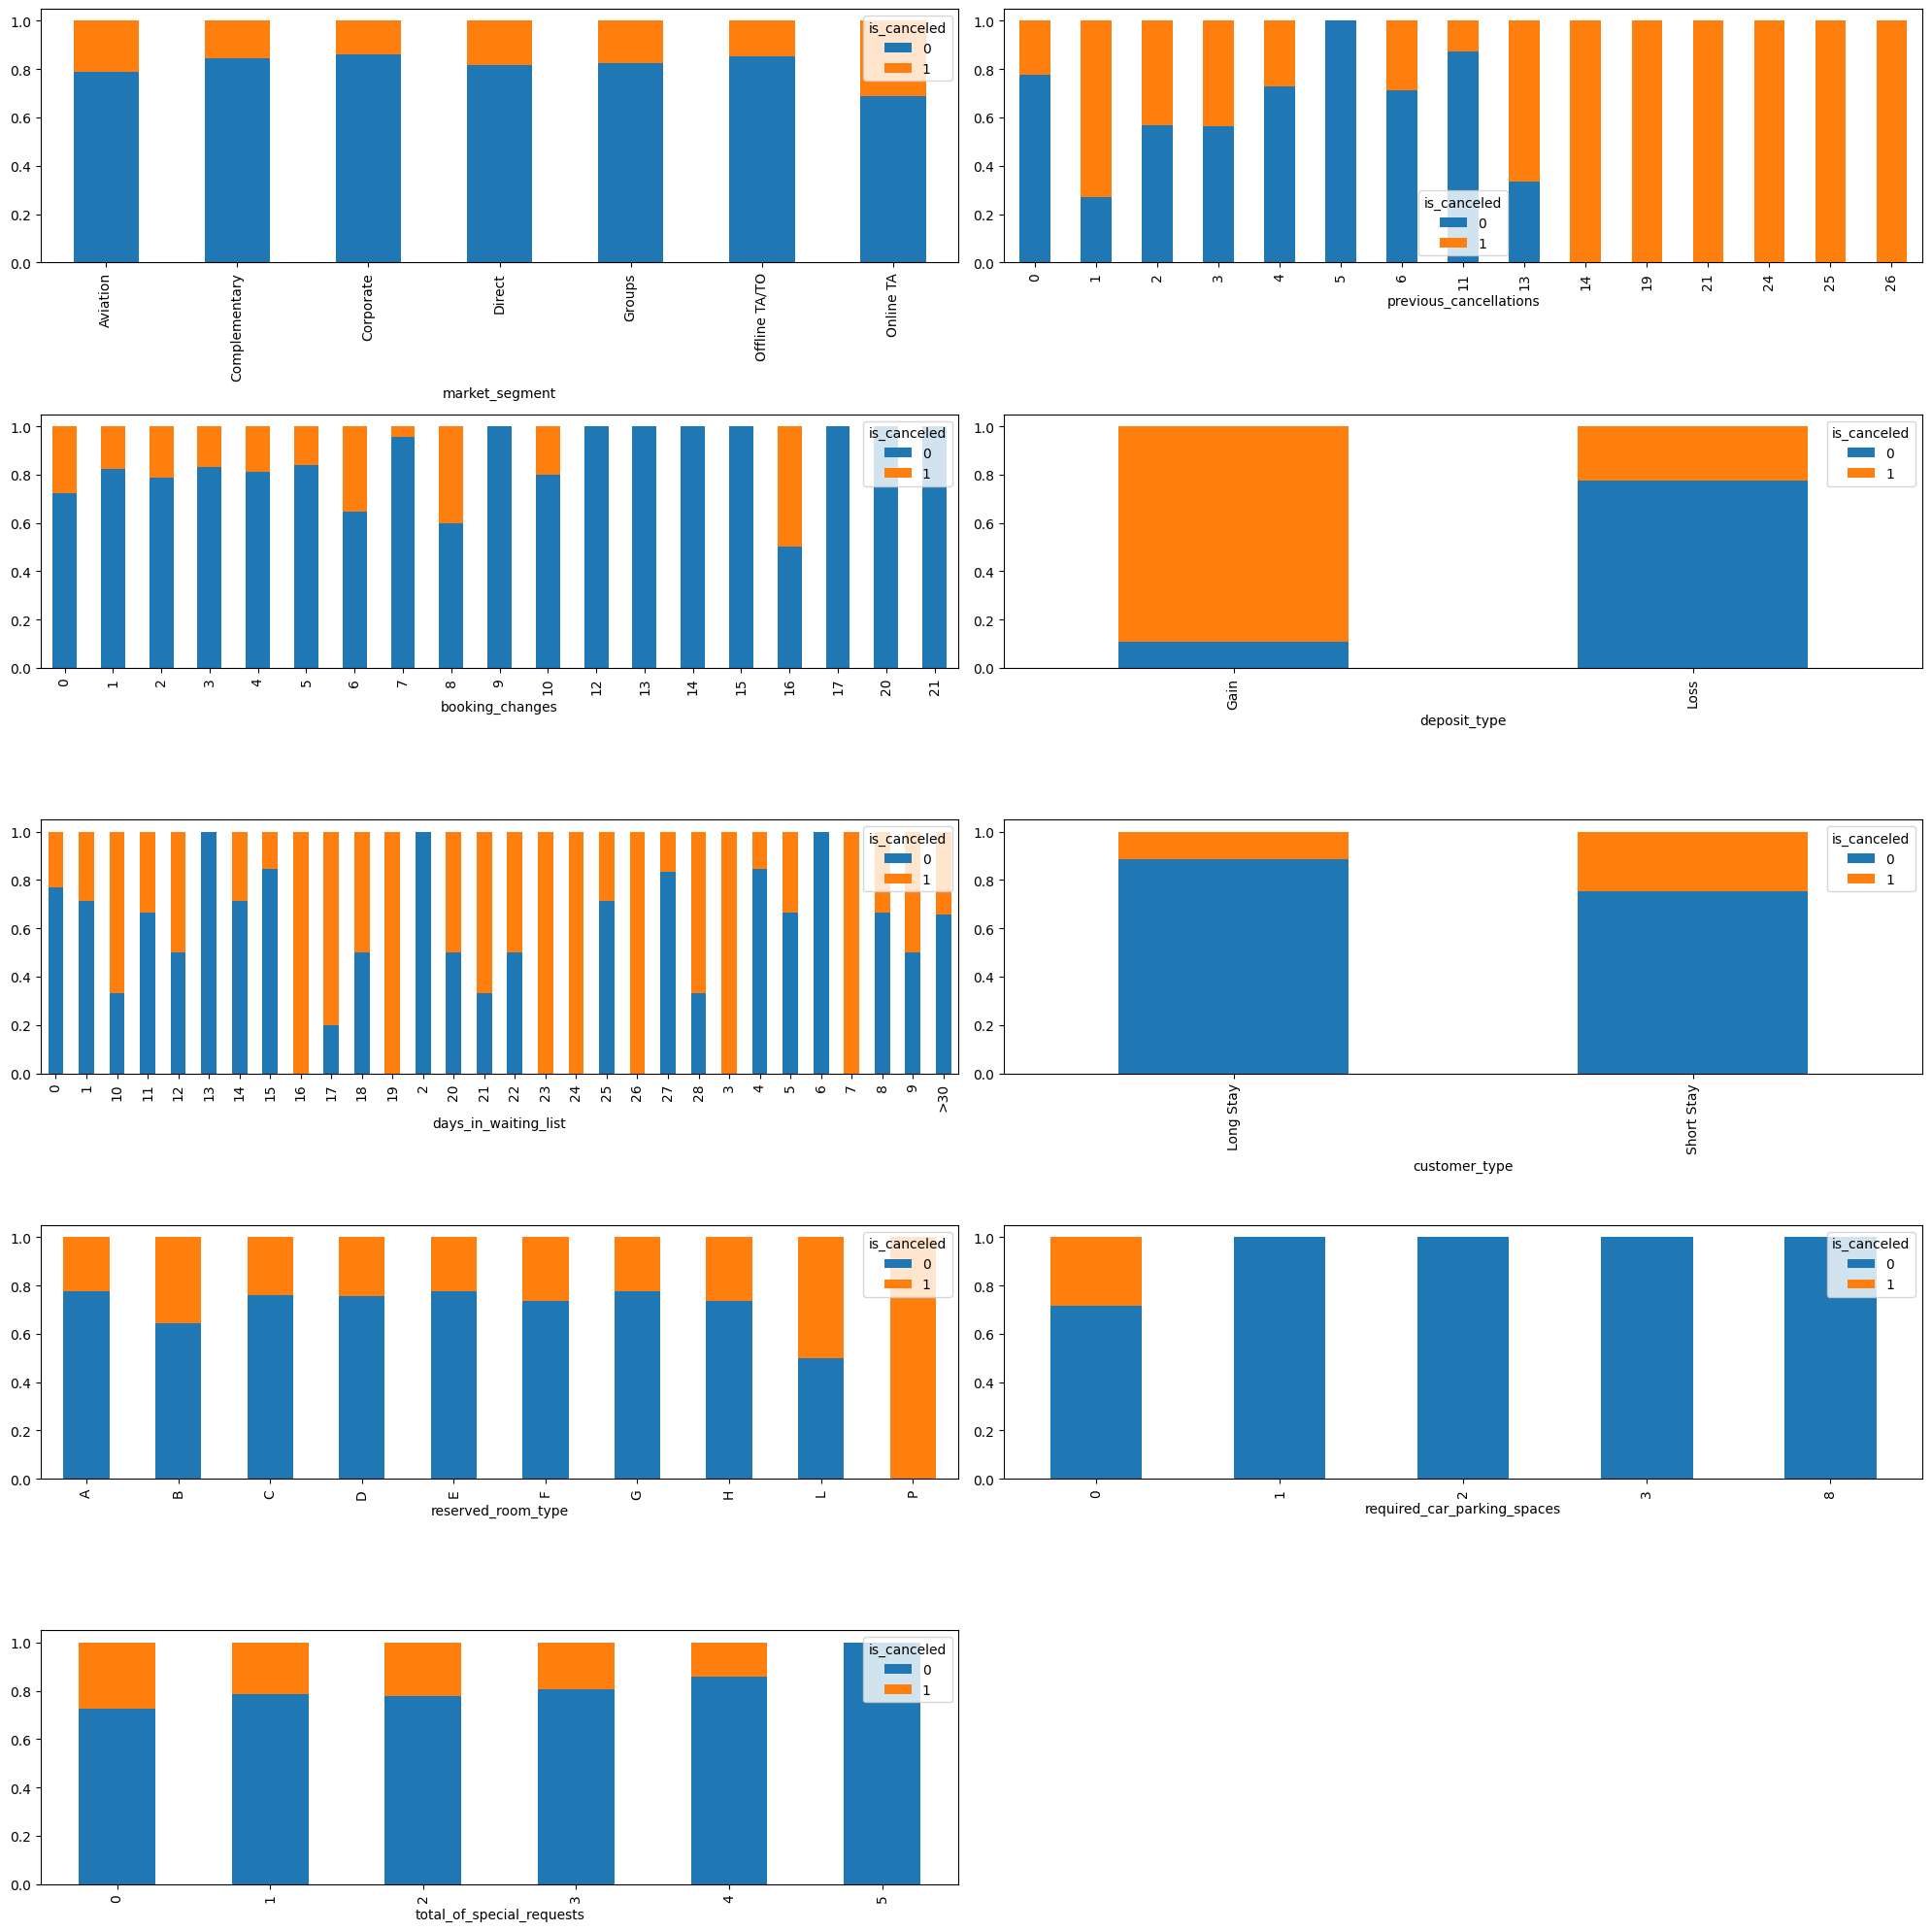

In [27]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['is_canceled','country']).columns:
    count +=1
    ax= plt.subplot(5,2,count)
    pd.crosstab(df[i],df['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [28]:
for i in df.drop(columns=['is_canceled','country']).columns:
    relevent_experience_df = df.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

is_canceled,0,1
market_segment,,
Online TA,0.688465,0.311535
Aviation,0.790123,0.209877
Direct,0.816739,0.183261
Groups,0.823669,0.176331
Complementary,0.844444,0.155556
Offline TA/TO,0.852961,0.147039
Corporate,0.861386,0.138614


is_canceled,0,1
previous_cancellations,,
14,NaN,1.000000
19,NaN,1.000000
21,NaN,1.000000
24,NaN,1.000000
25,NaN,1.000000
26,NaN,1.000000
1,0.268482,0.731518
13,0.333333,0.666667
3,0.565217,0.434783


is_canceled,0,1
booking_changes,,
16,0.500000,0.500000
8,0.600000,0.400000
6,0.647059,0.352941
0,0.722694,0.277306
2,0.787879,0.212121
10,0.800000,0.200000
4,0.812808,0.187192
1,0.822376,0.177624
3,0.831111,0.168889


is_canceled,0,1
deposit_type,,
Gain,0.108247,0.891753
Loss,0.775306,0.224694


is_canceled,0,1
days_in_waiting_list,,
26,NaN,1.000000
7,NaN,1.000000
3,NaN,1.000000
16,NaN,1.000000
19,NaN,1.000000
23,NaN,1.000000
24,NaN,1.000000
17,0.200000,0.800000
10,0.333333,0.666667


is_canceled,0,1
customer_type,,
Short Stay,0.753018,0.246982
Long Stay,0.885042,0.114958


is_canceled,0,1
reserved_room_type,,
P,NaN,1.000000
L,0.500000,0.500000
B,0.644592,0.355408
H,0.734375,0.265625
F,0.737063,0.262937
D,0.754568,0.245432
C,0.761062,0.238938
E,0.775641,0.224359
G,0.776557,0.223443


is_canceled,0,1
required_car_parking_spaces,,
0,0.716669,0.283331
1,1.000000,NaN
2,1.000000,NaN
3,1.000000,NaN
8,1.000000,NaN


is_canceled,0,1
total_of_special_requests,,
0,0.725928,0.274072
2,0.780177,0.219823
1,0.787788,0.212212
3,0.806638,0.193362
4,0.857143,0.142857
5,1.000000,NaN


Dari Barplot dan Table di atas, maka dapat ditarik analisa sebagai berikut:
1. market_segment               : Cancelation paling banyak terjadi pada transaksi melalui perantara TA/Traveling Agents 
2. previous_cancellations       : Cancelation paling banyak terjadi pada transaksi dimana customer sudah membatalkan transaksi sebelumnya sebanyak 10 kali atau lebih
3. booking_changes              : Untuk rate cancelation pada column ini, tidak terlalu memiliki perbedaan yang mencolok antara jumlah booking changes dengan yang lainnya
4. deposit_type                 : Transaksi yang tidak ada deposit atau layanan refund memiliki tingkat cancelation yang sangat tinggi dibandingkan transaksi dengan type sebaliknya
5. days_in_waiting_list         : Untuk rate cancelation pada column ini, tidak terlalu memiliki perbedaan yang mencolok antara jumlah booking changes dengan yang lainnya
6. customer_type                : Untuk transaksi dengan periode waktu inap sementara/singkat (short stay) memiliki tingkat cancelation lebih tinggi
7. reserved_room_type           : Untuk tipe kamar P,L,B memiliki tingkat cancellation paling tinggi dibandinkan tipe kamar lain
8. required_car_parking_spaces  : Tingkat cancelation pada transaksi yang tidak membutuhkan parkir lebih tinggi dibanding transaksi lain
9. total_of_special_requests    : Cancelation paling sering terjadi pada transaksi yang tidak memiliki permintaan layanan khusus

Untuk column country kita akan analisis menggunakan perbandingan persetase untuk melihat apakah ada perbedaan rate cancelation dari setiap negara.
Karena data negaranya ada banyak, maka kita lihat untuk 4 negara dengan jumlah data terbanyak.

In [29]:
df['country'].value_counts()

PRT    1992
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
LCA       1
ZMB       1
GTM       1
UMI       1
AIA       1
Name: country, Length: 162, dtype: int64

In [30]:
country_df = df.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_df.sort_values(by=[1.0], ascending=False).loc['PRT']

is_canceled
0    0.633032
1    0.366968
Name: PRT, dtype: float64

In [31]:
country_df = df.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_df.sort_values(by=[1.0], ascending=False).loc['GBR']

is_canceled
0    0.836512
1    0.163488
Name: GBR, dtype: float64

In [32]:
country_df = df.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_df.sort_values(by=[1.0], ascending=False).loc['ESP']

is_canceled
0    0.809672
1    0.190328
Name: ESP, dtype: float64

In [33]:
country_df = df.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_df.sort_values(by=[1.0], ascending=False).loc['DEU']

is_canceled
0    0.833333
1    0.166667
Name: DEU, dtype: float64

Dari perbandingan perbandingan diatas, dapat kita lihat bahwa Inggris (GBR) memiliki rating yang hampir sama dengan Jerman (DEU). Lalu untuk customer dari Spanyol (ESP) memiliki rating cancelation yang lebih tinggi daripada GBR dan DEU. Sedangkan untuk Portugal (PRT) memiliki rating yang sangat tinggi (sekitar 36%) dimana customer PRT merupakan customer domestic atau dalam negeri.

## Data Preparation 

In [34]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,Loss,0,Short Stay,A,0,0,0
1,FRA,Online TA,0,0,Loss,0,Short Stay,A,0,2,0
2,PRT,Online TA,0,1,Loss,0,Short Stay,A,0,2,0
3,NLD,Online TA,0,0,Loss,0,Short Stay,A,0,1,1
4,PRT,Online TA,0,2,Loss,0,Short Stay,A,0,2,0


In [35]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(10083, 11)


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[TZA, CIV]"
1,market_segment,object,0,0.0,7,"[Online TA, Direct]"
2,previous_cancellations,int64,0,0.0,15,"[2, 26]"
3,booking_changes,int64,0,0.0,19,"[8, 5]"
4,deposit_type,object,0,0.0,2,"[Loss, Gain]"
5,days_in_waiting_list,object,0,0.0,30,"[9, 23]"
6,customer_type,object,0,0.0,2,"[Long Stay, Short Stay]"
7,reserved_room_type,object,0,0.0,10,"[G, D]"
8,required_car_parking_spaces,int64,0,0.0,5,"[3, 8]"
9,total_of_special_requests,int64,0,0.0,6,"[2, 3]"


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `country` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
2. Merubah fitur/kolom `market_segment` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `deposit_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `customer_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
5. Merubah fitur/kolom `reserved_room_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
6. Merubah fitur/kolom `days_in_waiting_list` menggunakan Ordinal Encoding, karena fitur ini berbentuk range dimana menunjukan lamanya hari sampai transaksi booking selesai. Untuk jumlah hari yang lebih dari 30, makan akan kita ubah menjadi >30.


In [36]:
ordinal_mapping = [
    {'col':'days_in_waiting_list',
    'mapping':{
        '0'       :    0,
        '1'       :    1, 
        '2'       :    2, 
        '3'       :    3, 
        '4'       :    4, 
        '5'       :    5,
        '6'       :    6,
        '7'       :    7,
        '8'       :    8, 
        '9'       :    9, 
        '10'      :    10, 
        '11'      :    11,
        '12'      :    12,
        '13'      :    13, 
        '14'      :    14, 
        '15'      :    15, 
        '16'      :    16,
        '17'      :    17,
        '18'      :    18,
        '19'      :    19, 
        '20'      :    20, 
        '21'      :    21,
        '22'      :    22,
        '23'      :    23,
        '24'      :    24,
        '25'      :    25,
        '26'      :    26,
        '27'      :    27,
        '28'      :    28,
        '29'      :    29,
        '>30'     :    30,
    }}
]

In [37]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['days_in_waiting_list']),
    ('binary', ce.BinaryEncoder(), ['country'])
], remainder='passthrough')

In [38]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=1)

In [40]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
testing.tail()

,onehot__market_segment_Complementary,onehot__market_segment_Corporate,onehot__market_segment_Direct,onehot__market_segment_Groups,onehot__market_segment_Offline TA/TO,onehot__market_segment_Online TA,onehot__deposit_type_Loss,onehot__customer_type_Short Stay,onehot__reserved_room_type_B,onehot__reserved_room_type_C,onehot__reserved_room_type_D,onehot__reserved_room_type_E,onehot__reserved_room_type_F,onehot__reserved_room_type_G,onehot__reserved_room_type_H,onehot__reserved_room_type_L,onehot__reserved_room_type_P,ordinal__days_in_waiting_list,binary__country_0,binary__country_1,binary__country_2,binary__country_3,binary__country_4,binary__country_5,binary__country_6,binary__country_7,remainder__previous_cancellations,remainder__booking_changes,remainder__required_car_parking_spaces,remainder__total_of_special_requests
8061,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8062,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0
8063,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
8064,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
8065,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modeling & Evaluation

In [41]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

In [42]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
LightGBM,0.808610,0.009576
XGBoost,0.800122,0.009287
Logistic Regression,0.795463,0.004992
Random Forest,0.690041,0.010651
KNN,0.680843,0.007786
Decision Tree,0.562510,0.013772


Dapat dilihat, setelah dilakukan test dengan hyperparameter standard model LightGBM memiliki score roc_auc yang tertinggi.

### Model Benchmarking : Test Data

In [43]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.80      0.95      0.87      1538
           1       0.61      0.24      0.34       479

    accuracy                           0.78      2017
   macro avg       0.70      0.60      0.61      2017
weighted avg       0.75      0.78      0.74      2017

KNN 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      1538
           1       0.43      0.30      0.35       479

    accuracy                           0.74      2017
   macro avg       0.62      0.59      0.60      2017
weighted avg       0.71      0.74      0.72      2017

Decision Tree 
               precision    recall  f1-score   support

           0       0.78      0.83      0.80      1538
           1       0.31      0.25      0.28       479

    accuracy                           0.69      2017
   macro avg       0.55      0.54      0.54      2017
weighted avg       0.67      0

,roc_auc score
model,
LightGBM,0.818530
XGBoost,0.815043
Logistic Regression,0.802360
KNN,0.700807
Random Forest,0.681263
Decision Tree,0.558336


Setelah di-test dengan benchmarking, LightGBM memiliki score roc_auc yang tinggi lagi.

Dengan begini, kita akan menggunakan model lightGBM untuk test oversampling sebelum melakukan tuning pada hyperparameternya.

### Test Oversampling with K-Fold Cross Validation

In [44]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [45]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [46]:
data = x_train
target = y_train

In [47]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

In [48]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.814713,0.789343,0.877385,0.825330,0.681944,0.648346,0.354988,0.328125,0.724260,0.605769
1,0.814988,0.781908,0.881667,0.786958,0.687357,0.628079,0.370650,0.291667,0.712375,0.583333
2,0.816779,0.776952,0.878235,0.809769,0.688620,0.606648,0.368910,0.250000,0.724374,0.571429
3,0.814713,0.793061,0.880324,0.810671,0.681555,0.646135,0.353828,0.312500,0.725327,0.631579
4,0.811820,0.780669,0.878246,0.802642,0.675688,0.626979,0.345128,0.291667,0.715144,0.577320
5,0.815815,0.780669,0.880255,0.815710,0.690226,0.634822,0.377030,0.312500,0.711939,0.571429
6,0.813912,0.803970,0.879187,0.820381,0.682086,0.662343,0.357681,0.329843,0.717442,0.677419
7,0.813774,0.777916,0.874723,0.814962,0.679416,0.612070,0.350145,0.261780,0.723353,0.568182
8,0.815152,0.784119,0.877902,0.810322,0.688433,0.634191,0.373333,0.303665,0.711602,0.585859
9,0.815152,0.789082,0.878886,0.817656,0.685442,0.648248,0.364058,0.329843,0.719359,0.600000


In [49]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.807859,0.681537,0.882923,0.826850,0.804622,0.653911,0.936585,0.838542,0.744828,0.416021
1,0.812918,0.657993,0.888475,0.787390,0.810098,0.625711,0.934779,0.765625,0.751598,0.388889
2,0.806504,0.707559,0.885655,0.809201,0.803441,0.673977,0.931346,0.812500,0.745265,0.438202
3,0.805059,0.688971,0.885393,0.814609,0.802273,0.657677,0.923758,0.812500,0.746532,0.420485
4,0.807588,0.684015,0.883566,0.800470,0.804470,0.652222,0.933875,0.802083,0.745565,0.415094
5,0.808220,0.706320,0.886422,0.820300,0.805543,0.670523,0.925565,0.791667,0.749634,0.435530
6,0.809756,0.702233,0.889144,0.821313,0.806841,0.672191,0.932611,0.842932,0.748658,0.433962
7,0.804246,0.700993,0.883653,0.816933,0.801196,0.671635,0.928094,0.848168,0.743846,0.433155
8,0.803975,0.687345,0.883634,0.810271,0.800971,0.654649,0.926829,0.801047,0.744017,0.416894
9,0.807859,0.696030,0.884433,0.815924,0.804658,0.662220,0.935863,0.801047,0.745109,0.425000


Kesimpulan yang dapat diambil:
1. Recall
- Without Oversampling    : -
- With Oversampling       : +
- Untuk recallnya lebih baik setelah dilakukan oversampling

2. Precision
- Without Oversampling    : +
- With Oversampling       : -
- Untuk precision menurun setelah dilakukan oversampling, ini disebabkan oleh jumlah data untuk class positive bertambah dan menyebabkan presisi untuk menebak customer yang memiliki potensi membatalkan transaksi booking menjadi lebih sulit. Tentu saja ini dapat menyebabkan kehilangan calon customer yang dapat menyelesaikan transaksi.

Dari pengukuran kedua hal di atas, model yang akan kita gunakan akan bergantung pada target perusahaan. Jika perusahaan ingin lebih baik dalam memprediksi calon customer yang benar benar akan membatalkan order maka tidak perlu dilakukan oversampling, karena sebelum oversampling presisi untuk menentukan true positive class sudah baik.

Mari sekarang kita lihat juga classification reportsnya.

In [50]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       615
           1       0.61      0.33      0.43       192

    accuracy                           0.79       807
   macro avg       0.71      0.63      0.65       807
weighted avg       0.77      0.79      0.77       807

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       615
           1       0.58      0.29      0.39       192

    accuracy                           0.78       807
   macro avg       0.70      0.61      0.63       807
weighted avg       0.76      0.78      0.75       807

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       615
           1       0.57      0.25      0.35       192

    accuracy                           0.78       807
   macro avg       0.69      0.60      0.61       807
weighted avg       0.75      0.78      0.74       807

              preci

In [51]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.93      0.63      0.75       615
           1       0.42      0.84      0.56       192

    accuracy                           0.68       807
   macro avg       0.67      0.74      0.65       807
weighted avg       0.80      0.68      0.71       807

              precision    recall  f1-score   support

           0       0.90      0.62      0.74       615
           1       0.39      0.77      0.52       192

    accuracy                           0.66       807
   macro avg       0.64      0.70      0.63       807
weighted avg       0.77      0.66      0.68       807

              precision    recall  f1-score   support

           0       0.92      0.67      0.78       615
           1       0.44      0.81      0.57       192

    accuracy                           0.71       807
   macro avg       0.68      0.74      0.67       807
weighted avg       0.81      0.71      0.73       807

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari positive class dan negative class lebih seimbang, dengan posistive class lebih banyak.
Dengan begini kita dapat menggunakan model dengan oversampling dan mengasumsikan perusahaan lebih ingin memprediksi customer yang memiliki potensi membatalkan transaksi agar terhindar dari biaya tambahan yang sia sia.

Selanjutnya kita akan melakukan hyperparameter tuning terhadap model LightGBM-nya.

## Hyperparameter Tuning

In [52]:
x_train.dtypes

country                        object
market_segment                 object
previous_cancellations          int64
booking_changes                 int64
deposit_type                   object
days_in_waiting_list           object
customer_type                  object
reserved_room_type             object
required_car_parking_spaces     int64
total_of_special_requests       int64
dtype: object

In [53]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [54]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}]

In [55]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [56]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
0.8237320469572497
{'model__learning_rate': 0.05, 'model__max_bin': 255, 'model__min_data_in_leaf': 20, 'model__num_iterations': 75, 'model__num_leaves': 21, 'model__random_state': 42}


Hyperparameter terbaik LGBM dari hasil Gridsearch adalah sebagai berikut
- `max_bin` = 255, `num_leaves` = 21, `min_data_in_leaf` = 20, `num_iterations` = 75, `learning_rate` = 0.05

In [57]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'days_in_waiting_list',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': 0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     10
11     11
12     12
13     13
14     14
15     15
16     16
17     17
18     18
19     19
20     20
21     21
22     22
23     23
24     24
25     25
26     26
27     27
28     28
29     29
>30    30
dtype: int64}]),
                                                  ['days_in_waiting_list']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, max_bin=255,
                                min_data_in_leaf=20, num_iterations=75,
                                num_leaves=21, random_state=42))])

In [58]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'days_in_waiting_list',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': 0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     10
11     11
12     12
13     13
14     14
15     15
16     16
17     17
18     18
19     19
20     20
21     21
22     22
23     23
24     24
25     25
26     26
27     27
28     28
29     29
>30    30
dtype: int64}]),
                                                  ['days_in_waiting_list']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country'])])),
                ('model', LGBMClassifier())])

In [59]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.8191337881531473
ROC AUC Score Tuned LGBM :  0.8275442444842013


Setelah dilakukan hyperparameter tuning, kita dapat melihat bahwa ROC AUC scorenya meningkat.
Mari kita coba lihat kembali classification reportnya setelah melakukan hyperparameter tuning.

In [60]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.66      0.77      1538
           1       0.44      0.85      0.58       479

    accuracy                           0.70      2017
   macro avg       0.68      0.75      0.67      2017
weighted avg       0.81      0.70      0.73      2017

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.63      0.76      1538
           1       0.43      0.89      0.58       479

    accuracy                           0.69      2017
   macro avg       0.69      0.76      0.67      2017
weighted avg       0.83      0.69      0.71      2017



Setelah dilakukan tuning, model LGBM lebih baik dalam melakukan recall walaupun seperti yang kita tahu precision nya menjadi lebih berkurang. Tetapi karena precisionnya berkurang sedikit saja dibandikan kenaikan recall yang lebih besar maka model LGBM yang setelah dituning overall lebih baik dan masih sejalan dengan tujuan perusahaan. Oleh karena itu kita akan menggunakan model LGBM yang sudah di tuned sebagai model akhir kita.

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LGBM kita

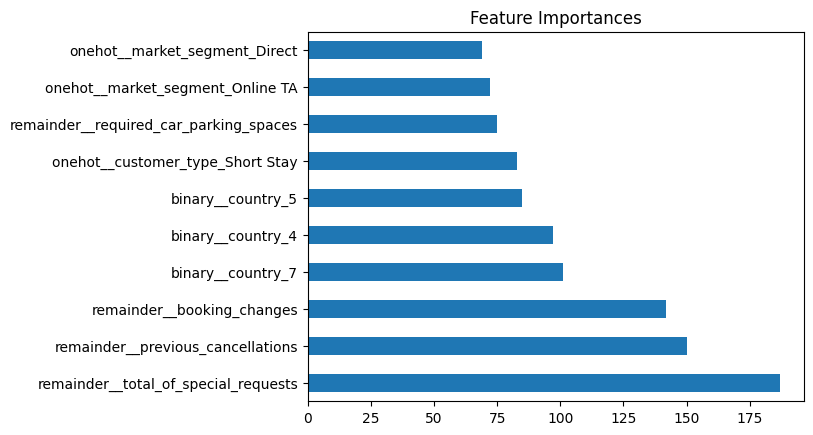

In [61]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Dari figure diatas, kita dapat melihat bahwa column total_of_special_request adalah yang paling penting. Diikuti column previous_cancellations dan booking_changes yang juga memiliki potensi menentukan calon customer yang potensial.

## Conclusion & Recommendation

In [62]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.63      0.76      1538
           1       0.43      0.89      0.58       479

    accuracy                           0.69      2017
   macro avg       0.69      0.76      0.67      2017
weighted avg       0.83      0.69      0.71      2017



#### Conclusion

Berdasarkan hasil classification report dari model kita, maka dapat disimpulkan:
1. **RECALL**
- Model dapat menyisihkan sebanyak 63% dari total calon customer sebagai customer yang berpotensi tidak membatalkan transaksi booking
- DModel dapat menentukan sebanyak 89% dari total calong customer sebagai customer yang berpotensi membatalkan transaksi booking

2. **PRECISION**
- Model dapat menentukan calon customer yang benar benar berpotensi membatalkan transaksi booking dengan rating ketepatan sebesar 43%

Jadi walaupun model lebih dapat menentukan customer yang memiliki potensi membatalkan transaksi booking tetapi ketepatannya untuk menentukan customer benar benar berpotensi lebih kecil.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Menambahkan fitur atau kolom baru yang kemungkinan bisa membantu membuat suatu prediksi yang lebih tepat, misalnya column alasan mengapa seorang customer bisa membatalkan suatu transaksi.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda juga selain Random Over Sampling, seperti SMOTENC, dll. 
- Menganalisa lebih dalam untuk data-data yang model masih salah tebak untuk mengetahui alasan yang lebih pasti dan ciri/karateristiknya customer yang akan membatalkan transaksi itu bagaimana.

In [65]:
import pickle
filename = 'Hotel_Booking_Demand_Finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))